# Dublin Rent Predictor - Machine Learning Pipeline

This notebook demonstrates the complete machine learning pipeline for predicting rental prices in Dublin, Ireland.

## Overview
- **Data Source**: Dublin rental listings scraped from Daft.ie
- **Model**: Random Forest Regressor
- **Features**: Bedrooms, Bathrooms, Property Type, Dublin Area
- **Target**: Monthly rent price in EUR

## Table of Contents
1. [Data Loading & Exploration](#1-data-loading--exploration)
2. [Data Cleaning & Preprocessing](#2-data-cleaning--preprocessing)
3. [Feature Engineering](#3-feature-engineering)
4. [Model Training](#4-model-training)
5. [Model Evaluation](#5-model-evaluation)
6. [Feature Importance Analysis](#6-feature-importance-analysis)
7. [Making Predictions](#7-making-predictions)
8. [Model Persistence](#8-model-persistence)

## Setup & Imports

In [4]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import json
import os

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('default')
sns.set_palette("husl")

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## 1. Data Loading & Exploration

In [5]:
# Load the dataset
data_path = '../data/train.csv'
df = pd.read_csv(data_path)

print(f"📊 Dataset loaded: {len(df)} records")
print(f"📋 Columns: {list(df.columns)}")
print("\n🔍 First 5 rows:")
df.head()

📊 Dataset loaded: 913 records
📋 Columns: ['price', 'beds', 'baths', 'prop_type', 'address', 'link']

🔍 First 5 rows:


,price,beds,baths,prop_type,address,link
0,2612.0,1,1,Apartment,"Cathedral Court, Unit 6 New Street South, Dubl...",https://www.daft.ie/for-rent/apartment-1-bedro...
1,3072.0,2,2,Apartment,"Cathedral Court, Unit 6 New Street South, Dubl...",https://www.daft.ie/for-rent/apartment-2-bedro...
2,3310.0,2,2,Apartment,"Cathedral Court, Unit 6 New Street South, Dubl...",https://www.daft.ie/for-rent/apartment-2-bedro...
3,1850.0,0,0,Studio,"Node Dublin 7, Phibsborough, D07 V10E, Dublin 7",https://www.daft.ie/for-rent/studio-apartment-...
4,1875.0,0,0,Studio,"Node Dublin 7, Phibsborough, D07 V10E, Dublin 7",https://www.daft.ie/for-rent/studio-apartment-...


In [6]:
# Basic dataset information
print("📈 Dataset Info:")
print(f"Shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\n📊 Data Types:")
print(df.dtypes)

print("\n🔍 Missing Values:")
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_data,
    'Percentage': missing_percent
})
print(missing_df[missing_df['Missing Count'] > 0])

📈 Dataset Info:
Shape: (913, 6)
Memory usage: 0.20 MB

📊 Data Types:
price        float64
beds           int64
baths          int64
prop_type     object
address       object
link          object
dtype: object

🔍 Missing Values:
           Missing Count  Percentage
price                 24    2.628697
prop_type              2    0.219058
link                 790   86.527930


In [7]:
# Explore unique values in categorical columns
print("🏠 Property Types:")
print(df['prop_type'].value_counts())

print("\n📍 Sample Addresses:")
print(df['address'].head(10).tolist())

🏠 Property Types:
prop_type
Apartment    576
House        242
Studio        93
Name: count, dtype: int64

📍 Sample Addresses:
['Cathedral Court, Unit 6 New Street South, Dublin 8', 'Cathedral Court, Unit 6 New Street South, Dublin 8', 'Cathedral Court, Unit 6 New Street South, Dublin 8', 'Node Dublin 7, Phibsborough, D07 V10E, Dublin 7', 'Node Dublin 7, Phibsborough, D07 V10E, Dublin 7', 'Node Dublin 7, Phibsborough, D07 V10E, Dublin 7', 'Griffith Wood, Griffith Avenue, Drumcondra, Dublin 9', 'Griffith Wood, Griffith Avenue, Drumcondra, Dublin 9', 'Griffith Wood, Griffith Avenue, Drumcondra, Dublin 9', "O'Callaghan Court , Erne Street Upper , Dublin 2"]


## 2. Data Cleaning & Preprocessing

In [8]:
# Function to extract Dublin postal codes from addresses
def extract_dublin_postal_code(address_series):
    """Extract numeric Dublin postal codes from address strings"""
    
    def extract_code(address):
        if pd.isna(address):
            return np.nan
        
        # Convert to string and make uppercase for consistent matching
        address_str = str(address).upper()
        
        # Pattern 1: "Dublin X" where X is 1-2 digits
        match = re.search(r"DUBLIN\s+(\d{1,2})", address_str)
        if match:
            return int(match.group(1))
        
        # Pattern 2: "DX" where X is 1-2 digits (e.g., D2, D15)
        match = re.search(r"\bD(\d{1,2})\b", address_str)
        if match:
            return int(match.group(1))
        
        # Pattern 3: "D0X" where X is a digit (e.g., D08)
        match = re.search(r"\bD0(\d)\b", address_str)
        if match:
            return int(match.group(1))
        
        return np.nan
    
    return address_series.apply(extract_code)

# Test the function with a few examples
test_addresses = [
    "Cathedral Court, Unit 6 New Street South, Dublin 8",
    "Node Dublin 7, Phibsborough, D07 V10E, Dublin 7",
    "Griffith Wood, Griffith Avenue, Drumcondra, Dublin 9"
]

print("🧪 Testing Dublin area extraction:")
for addr in test_addresses:
    extracted = extract_dublin_postal_code(pd.Series([addr]))[0]
    print(f"'{addr}' → Dublin {extracted}")

🧪 Testing Dublin area extraction:
'Cathedral Court, Unit 6 New Street South, Dublin 8' → Dublin 8
'Node Dublin 7, Phibsborough, D07 V10E, Dublin 7' → Dublin 7
'Griffith Wood, Griffith Avenue, Drumcondra, Dublin 9' → Dublin 9


In [9]:
# Clean the data
print("🧹 Cleaning data...")

# Create a copy for cleaning
df_clean = df.copy()

# Handle 'N/A' strings in price column
df_clean['price'] = df_clean['price'].replace('N/A', np.nan)

# Convert columns to numeric, coercing errors to NaN
df_clean['price'] = pd.to_numeric(df_clean['price'], errors='coerce')
df_clean['beds'] = pd.to_numeric(df_clean['beds'], errors='coerce')
df_clean['baths'] = pd.to_numeric(df_clean['baths'], errors='coerce')

# Extract Dublin postal codes
df_clean['dublin_area'] = extract_dublin_postal_code(df_clean['address'])

print(f"📊 Before cleaning: {len(df)} records")

# Drop rows with missing essential data
df_clean = df_clean.dropna(subset=['price', 'beds', 'baths', 'prop_type', 'dublin_area'])
print(f"📊 After removing missing values: {len(df_clean)} records")

# Filter out unrealistic prices (less than 500 or greater than 20000)
df_clean = df_clean[(df_clean['price'] >= 500) & (df_clean['price'] <= 20000)]
print(f"📊 After price filtering (€500-€20,000): {len(df_clean)} records")

print("\n✅ Data cleaning completed!")

🧹 Cleaning data...
📊 Before cleaning: 913 records
📊 After removing missing values: 776 records
📊 After price filtering (€500-€20,000): 776 records

✅ Data cleaning completed!


In [10]:
# Explore the cleaned data
print("📈 Cleaned Data Summary:")
print(df_clean.describe())

print("\n🏠 Property Types Distribution:")
print(df_clean['prop_type'].value_counts())

print("\n📍 Dublin Areas Distribution:")
dublin_areas = df_clean['dublin_area'].value_counts().sort_index()
print(dublin_areas)

📈 Cleaned Data Summary:
              price        beds       baths  dublin_area
count    776.000000  776.000000  776.000000   776.000000
mean    2809.034794    1.925258    1.458763     8.259021
std     1649.905056    1.264740    0.990718     5.831498
min      505.000000    0.000000    0.000000     1.000000
25%     1949.500000    1.000000    1.000000     4.000000
50%     2500.000000    2.000000    1.000000     7.000000
75%     3107.500000    2.000000    2.000000    13.000000
max    17000.000000   14.000000   14.000000    24.000000

🏠 Property Types Distribution:
prop_type
Apartment    500
House        202
Studio        74
Name: count, dtype: int64

📍 Dublin Areas Distribution:
dublin_area
1.0      55
2.0      58
3.0      42
4.0     133
5.0      13
6.0      79
7.0      48
8.0      77
9.0      31
10.0      4
11.0     22
12.0     16
13.0     23
14.0     23
15.0     49
16.0     12
17.0      4
18.0     53
20.0      8
22.0      9
24.0     17
Name: count, dtype: int64


## 3. Data Visualization & Analysis

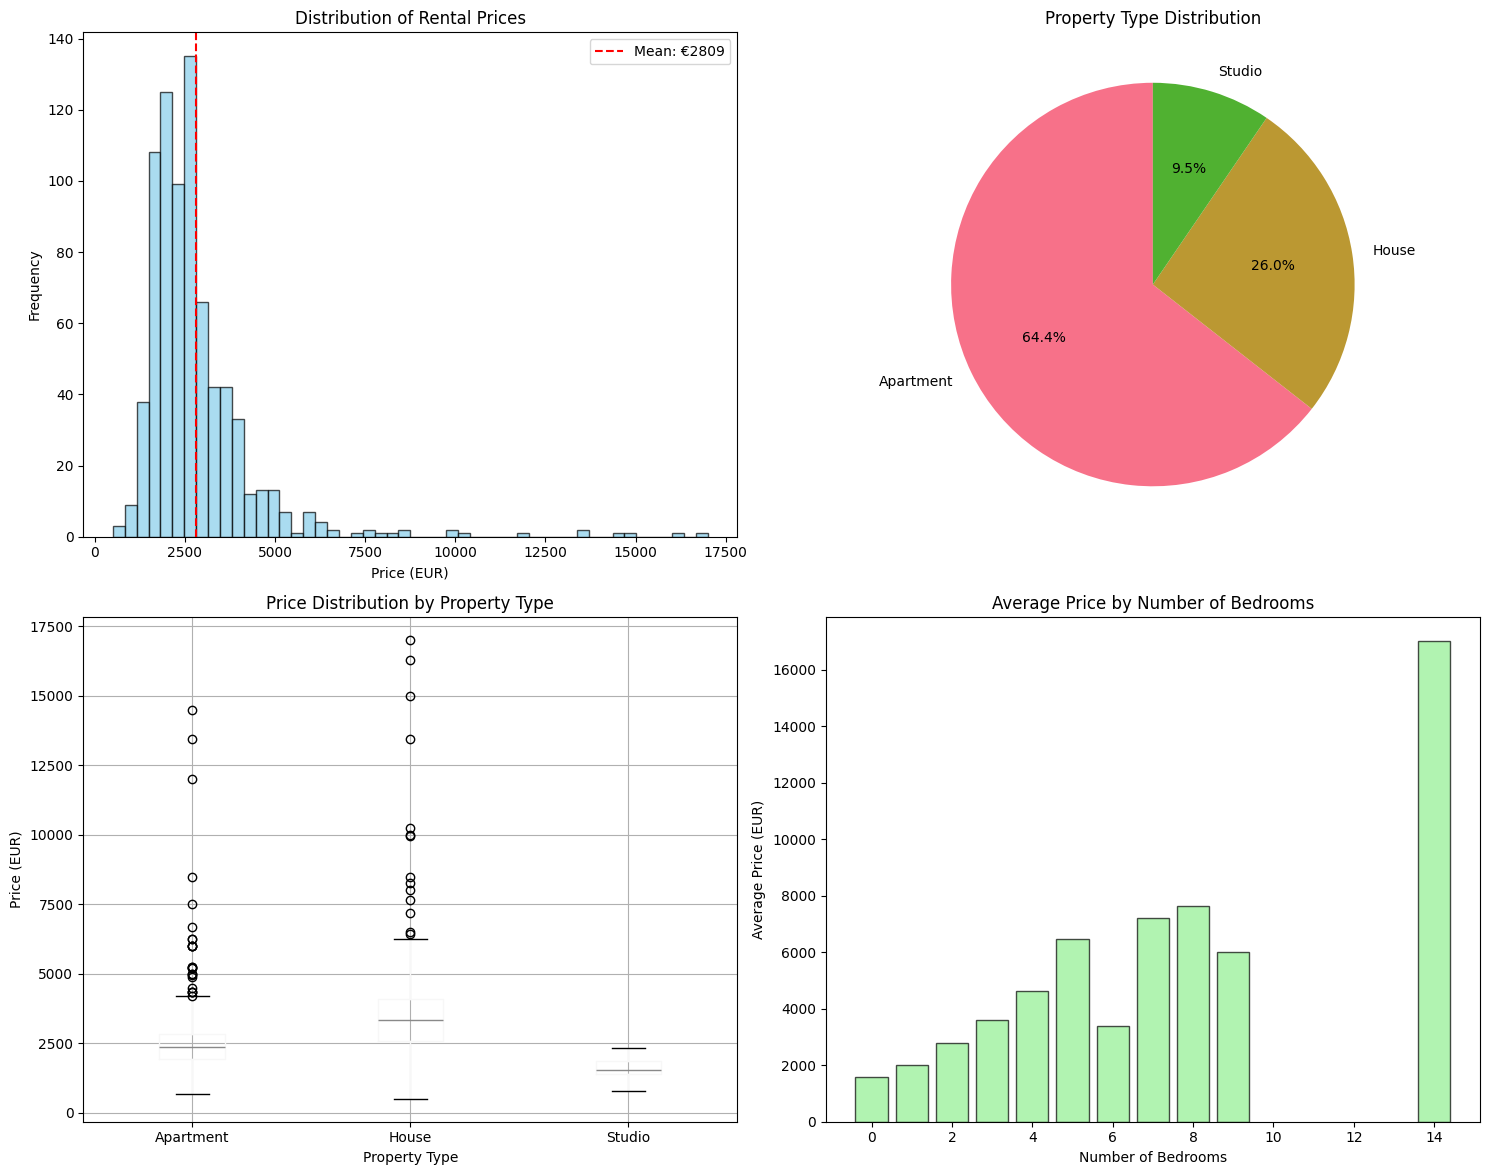

💰 Price Statistics:
Mean: €2809.03
Median: €2500.00
Min: €505.00
Max: €17000.00


In [11]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Price distribution
axes[0, 0].hist(df_clean['price'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribution of Rental Prices')
axes[0, 0].set_xlabel('Price (EUR)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(df_clean['price'].mean(), color='red', linestyle='--', label=f'Mean: €{df_clean["price"].mean():.0f}')
axes[0, 0].legend()

# Property type distribution
prop_counts = df_clean['prop_type'].value_counts()
axes[0, 1].pie(prop_counts.values, labels=prop_counts.index, autopct='%1.1f%%', startangle=90)
axes[0, 1].set_title('Property Type Distribution')

# Price by property type
df_clean.boxplot(column='price', by='prop_type', ax=axes[1, 0])
axes[1, 0].set_title('Price Distribution by Property Type')
axes[1, 0].set_xlabel('Property Type')
axes[1, 0].set_ylabel('Price (EUR)')
plt.suptitle('')  # Remove default title

# Bedrooms vs Price
bed_price = df_clean.groupby('beds')['price'].mean().sort_index()
axes[1, 1].bar(bed_price.index, bed_price.values, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1, 1].set_title('Average Price by Number of Bedrooms')
axes[1, 1].set_xlabel('Number of Bedrooms')
axes[1, 1].set_ylabel('Average Price (EUR)')

plt.tight_layout()
plt.show()

print(f"💰 Price Statistics:")
print(f"Mean: €{df_clean['price'].mean():.2f}")
print(f"Median: €{df_clean['price'].median():.2f}")
print(f"Min: €{df_clean['price'].min():.2f}")
print(f"Max: €{df_clean['price'].max():.2f}")

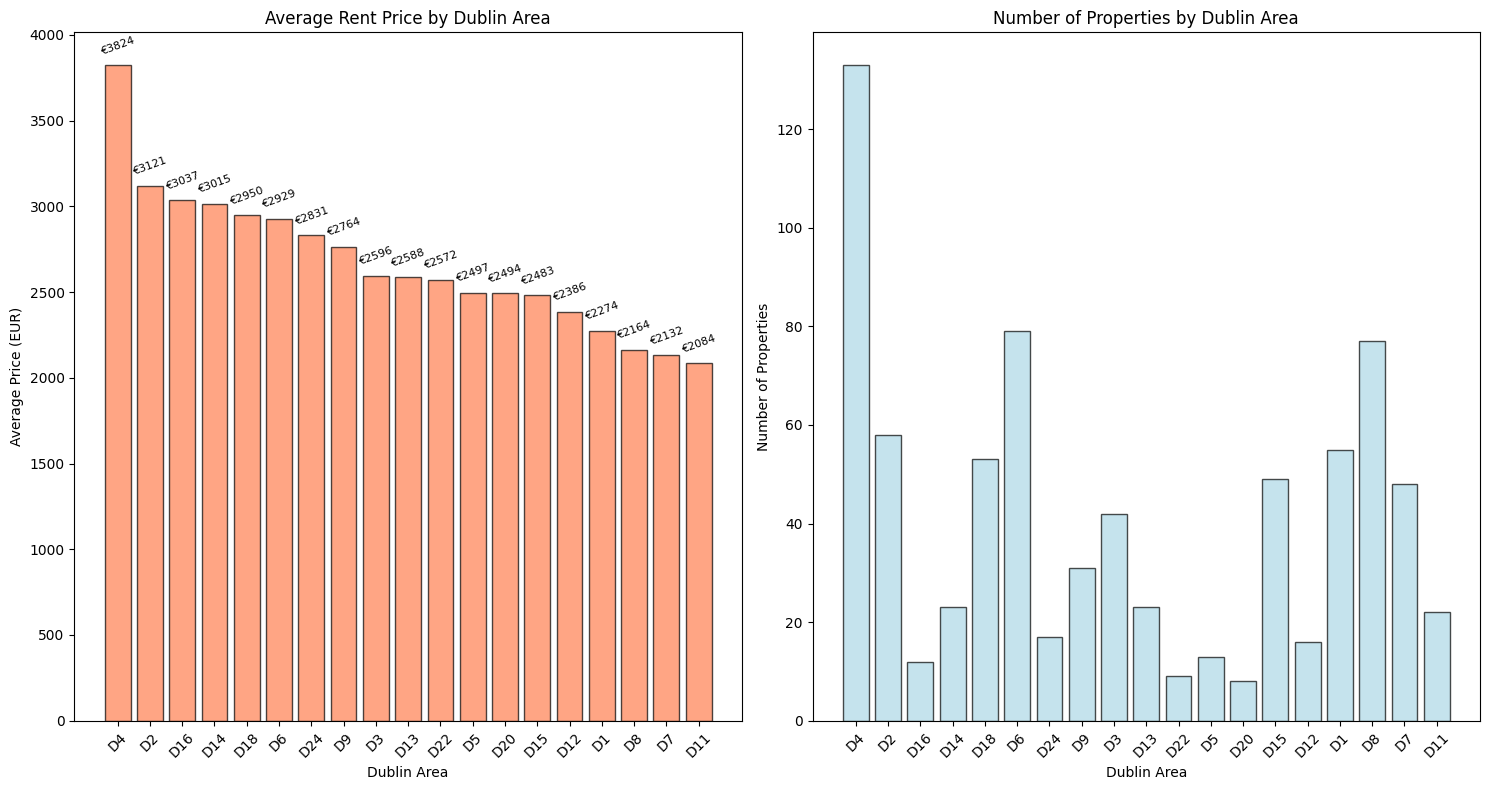

🏆 Top 5 Most Expensive Dublin Areas:
                    mean  count
dublin_area                    
4.0          3823.834586    133
2.0          3120.724138     58
16.0         3036.666667     12
14.0         3015.000000     23
18.0         2949.716981     53


In [12]:
# Dublin areas analysis
plt.figure(figsize=(15, 8))

# Average price by Dublin area
area_price = df_clean.groupby('dublin_area')['price'].agg(['mean', 'count']).sort_values('mean', ascending=False)
area_price = area_price[area_price['count'] >= 5]  # Only areas with at least 5 properties

plt.subplot(1, 2, 1)
bars = plt.bar(range(len(area_price)), area_price['mean'], alpha=0.7, color='coral', edgecolor='black')
plt.title('Average Rent Price by Dublin Area')
plt.xlabel('Dublin Area')
plt.ylabel('Average Price (EUR)')
plt.xticks(range(len(area_price)), [f'D{int(area)}' for area in area_price.index], rotation=45)

# Add value labels on bars with a 20 degree rotation
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 50,
             f'€{height:.0f}', ha='center', va='bottom', fontsize=8, rotation=20)

plt.subplot(1, 2, 2)
plt.bar(range(len(area_price)), area_price['count'], alpha=0.7, color='lightblue', edgecolor='black')
plt.title('Number of Properties by Dublin Area')
plt.xlabel('Dublin Area')
plt.ylabel('Number of Properties')
plt.xticks(range(len(area_price)), [f'D{int(area)}' for area in area_price.index], rotation=45)

plt.tight_layout()
plt.show()

print("🏆 Top 5 Most Expensive Dublin Areas:")
print(area_price.head())

## 4. Feature Engineering

In [13]:
# Prepare features for machine learning
print("🔧 Engineering features...")

# Initialize encoders
prop_type_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
dublin_area_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")

# Fit and transform categorical features
prop_type_encoded = prop_type_encoder.fit_transform(df_clean[['prop_type']])
dublin_area_encoded = dublin_area_encoder.fit_transform(df_clean[['dublin_area']])

# Create feature names
prop_type_features = [f"prop_type_{cat}" for cat in prop_type_encoder.categories_[0]]
dublin_area_features = [f"dublin_area_{int(cat)}" for cat in dublin_area_encoder.categories_[0]]

print(f"🏠 Property type features: {prop_type_features}")
print(f"📍 Dublin area features: {dublin_area_features}")

# Combine all features
X_numeric = df_clean[['beds', 'baths']].values
X = np.hstack([X_numeric, prop_type_encoded, dublin_area_encoded])

# Store feature names
feature_names = ['beds', 'baths'] + prop_type_features + dublin_area_features

# Target variable
y = df_clean['price'].values

print(f"\n✅ Feature engineering completed!")
print(f"📊 Feature matrix shape: {X.shape}")
print(f"📋 Feature names ({len(feature_names)}): {feature_names}")
print(f"🎯 Target shape: {y.shape}")

🔧 Engineering features...
🏠 Property type features: ['prop_type_Apartment', 'prop_type_House', 'prop_type_Studio']
📍 Dublin area features: ['dublin_area_1', 'dublin_area_2', 'dublin_area_3', 'dublin_area_4', 'dublin_area_5', 'dublin_area_6', 'dublin_area_7', 'dublin_area_8', 'dublin_area_9', 'dublin_area_10', 'dublin_area_11', 'dublin_area_12', 'dublin_area_13', 'dublin_area_14', 'dublin_area_15', 'dublin_area_16', 'dublin_area_17', 'dublin_area_18', 'dublin_area_20', 'dublin_area_22', 'dublin_area_24']

✅ Feature engineering completed!
📊 Feature matrix shape: (776, 26)
📋 Feature names (26): ['beds', 'baths', 'prop_type_Apartment', 'prop_type_House', 'prop_type_Studio', 'dublin_area_1', 'dublin_area_2', 'dublin_area_3', 'dublin_area_4', 'dublin_area_5', 'dublin_area_6', 'dublin_area_7', 'dublin_area_8', 'dublin_area_9', 'dublin_area_10', 'dublin_area_11', 'dublin_area_12', 'dublin_area_13', 'dublin_area_14', 'dublin_area_15', 'dublin_area_16', 'dublin_area_17', 'dublin_area_18', 'dubli

In [14]:
# Display feature matrix sample
feature_df = pd.DataFrame(X, columns=feature_names)
print("🔍 Feature Matrix Sample:")
print(feature_df.head(10))

print("\n📊 Feature Statistics:")
print(feature_df.describe())

🔍 Feature Matrix Sample:
   beds  baths  prop_type_Apartment  prop_type_House  prop_type_Studio  \
0   1.0    1.0                  1.0              0.0               0.0   
1   2.0    2.0                  1.0              0.0               0.0   
2   2.0    2.0                  1.0              0.0               0.0   
3   0.0    0.0                  0.0              0.0               1.0   
4   0.0    0.0                  0.0              0.0               1.0   
5   0.0    0.0                  0.0              0.0               1.0   
6   0.0    0.0                  0.0              0.0               1.0   
7   2.0    2.0                  1.0              0.0               0.0   
8   3.0    3.0                  1.0              0.0               0.0   
9   1.0    1.0                  1.0              0.0               0.0   

   dublin_area_1  dublin_area_2  dublin_area_3  dublin_area_4  dublin_area_5  \
0            0.0            0.0            0.0            0.0            0.0   


## 5. Model Training

In [15]:
# Split data for training and validation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"📊 Training set: {X_train.shape[0]} samples")
print(f"📊 Test set: {X_test.shape[0]} samples")
print(f"📊 Features: {X_train.shape[1]}")

📊 Training set: 620 samples
📊 Test set: 156 samples
📊 Features: 26


In [16]:
# Initialize and train the Random Forest model
print("🌲 Training Random Forest Regressor...")

model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    n_jobs=-1  # Use all available cores
)

# Train the model
model.fit(X_train, y_train)

print("✅ Model training completed!")
print(f"🌲 Number of trees: {model.n_estimators}")
print(f"🌲 Max depth: {model.max_depth}")

🌲 Training Random Forest Regressor...
✅ Model training completed!
🌲 Number of trees: 100
🌲 Max depth: 15


## 6. Model Evaluation

In [17]:
# Make predictions on test set
y_pred = model.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Calculate accuracy metrics (percentage of predictions within tolerance)
tolerance_10_percent = np.abs(y_pred - y_test) <= (0.10 * y_test)  # Within 10%
tolerance_20_percent = np.abs(y_pred - y_test) <= (0.20 * y_test)  # Within 20%
tolerance_500_euro = np.abs(y_pred - y_test) <= 500  # Within €500

accuracy_10_percent = np.mean(tolerance_10_percent) * 100
accuracy_20_percent = np.mean(tolerance_20_percent) * 100
accuracy_500_euro = np.mean(tolerance_500_euro) * 100

metrics = {
    'mae': mae,
    'mse': mse,
    'rmse': rmse,
    'r2': r2,
    'accuracy_10_percent': accuracy_10_percent,
    'accuracy_20_percent': accuracy_20_percent,
    'accuracy_500_euro': accuracy_500_euro,
    'training_samples': len(X_train),
    'test_samples': len(X_test)
}

print("📊 Model Performance Metrics:")
print(f"Mean Absolute Error (MAE): €{mae:.2f}")
print(f"Root Mean Square Error (RMSE): €{rmse:.2f}")
print(f"R² Score: {r2:.4f} ({r2*100:.1f}% variance explained)")
print()
print("🎯 Accuracy Metrics:")
print(f"Within 10% of actual price: {accuracy_10_percent:.1f}%")
print(f"Within 20% of actual price: {accuracy_20_percent:.1f}%")
print(f"Within €500 of actual price: {accuracy_500_euro:.1f}%")
print()
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

📊 Model Performance Metrics:
Mean Absolute Error (MAE): €469.31
Root Mean Square Error (RMSE): €805.36
R² Score: 0.4684 (46.8% variance explained)

🎯 Accuracy Metrics:
Within 10% of actual price: 47.4%
Within 20% of actual price: 77.6%
Within €500 of actual price: 69.9%

Training samples: 620
Test samples: 156


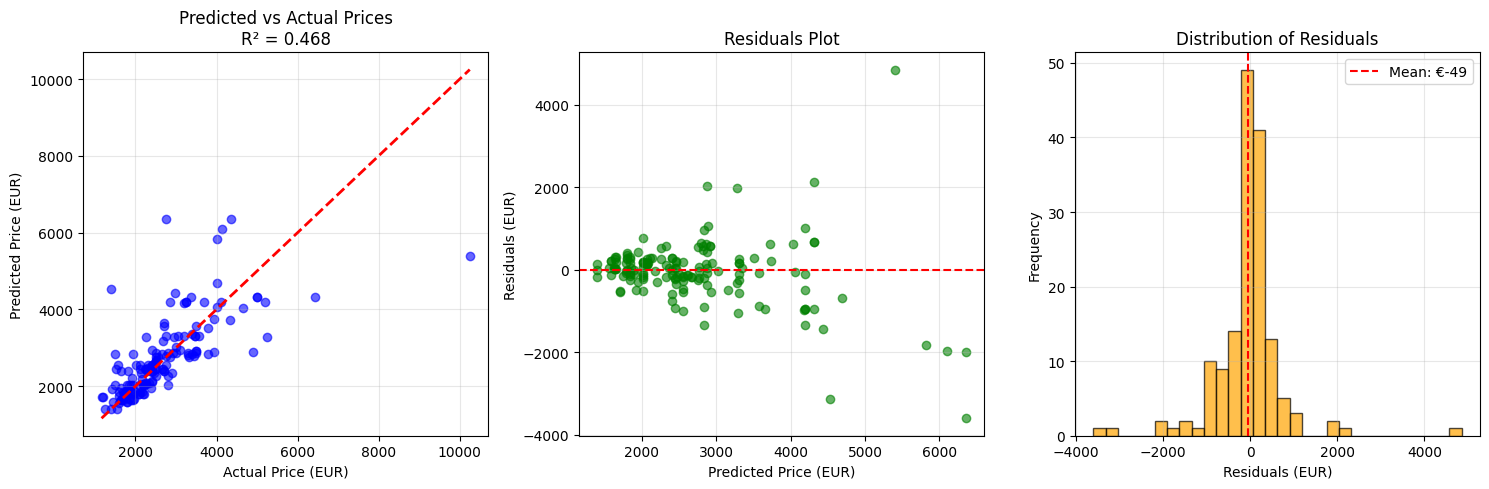

📊 Residual Statistics:
Mean residual: €-48.95
Std residual: €803.87
Min residual: €-3601.73
Max residual: €4854.23


In [18]:
# Visualize predictions vs actual values
plt.figure(figsize=(15, 5))

# Scatter plot: Predicted vs Actual
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price (EUR)')
plt.ylabel('Predicted Price (EUR)')
plt.title(f'Predicted vs Actual Prices\nR² = {r2:.3f}')
plt.grid(True, alpha=0.3)

# Residuals plot
residuals = y_test - y_pred
plt.subplot(1, 3, 2)
plt.scatter(y_pred, residuals, alpha=0.6, color='green')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Price (EUR)')
plt.ylabel('Residuals (EUR)')
plt.title('Residuals Plot')
plt.grid(True, alpha=0.3)

# Distribution of residuals
plt.subplot(1, 3, 3)
plt.hist(residuals, bins=30, alpha=0.7, color='orange', edgecolor='black')
plt.xlabel('Residuals (EUR)')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.axvline(residuals.mean(), color='red', linestyle='--', label=f'Mean: €{residuals.mean():.0f}')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"📊 Residual Statistics:")
print(f"Mean residual: €{residuals.mean():.2f}")
print(f"Std residual: €{residuals.std():.2f}")
print(f"Min residual: €{residuals.min():.2f}")
print(f"Max residual: €{residuals.max():.2f}")

## 7. Feature Importance Analysis

🎯 Feature Importance Rankings:
 1. baths                0.5347 (53.5%)
 2. beds                 0.2467 (24.7%)
 3. dublin_area_4        0.1153 (11.5%)
 4. dublin_area_24       0.0276 (2.8%)
 5. dublin_area_2        0.0168 (1.7%)
 6. prop_type_Apartment  0.0153 (1.5%)
 7. dublin_area_6        0.0122 (1.2%)
 8. prop_type_House      0.0092 (0.9%)
 9. dublin_area_14       0.0038 (0.4%)
10. dublin_area_8        0.0030 (0.3%)


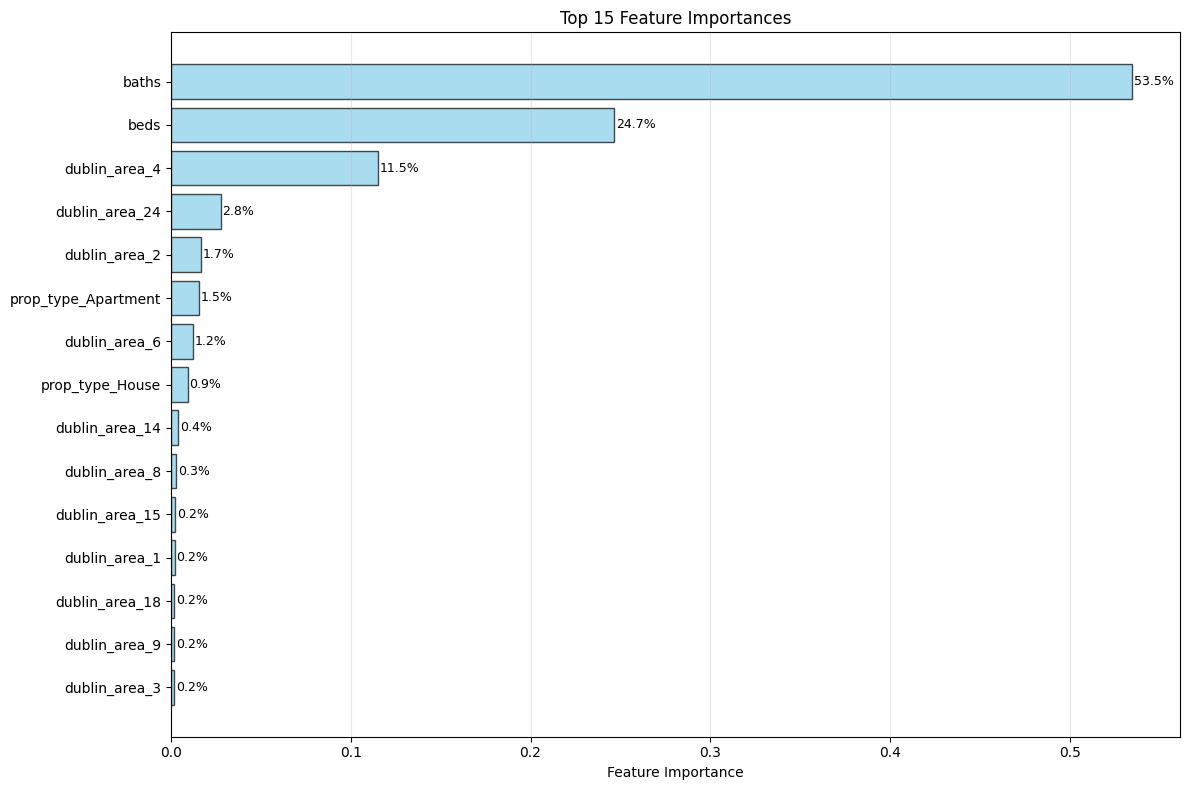

In [19]:
# Get feature importances
importance = model.feature_importances_
feature_importance = dict(zip(feature_names, importance))

# Sort by importance
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

print("🎯 Feature Importance Rankings:")
for i, (feature, imp) in enumerate(sorted_features[:10], 1):
    print(f"{i:2d}. {feature:<20} {imp:.4f} ({imp*100:.1f}%)")

# Visualize feature importance
plt.figure(figsize=(12, 8))
features, importances = zip(*sorted_features[:15])  # Top 15 features
y_pos = np.arange(len(features))

plt.barh(y_pos, importances, alpha=0.7, color='skyblue', edgecolor='black')
plt.yticks(y_pos, features)
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importances')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')

# Add percentage labels
for i, importance in enumerate(importances):
    plt.text(importance + 0.001, i, f'{importance*100:.1f}%', 
             va='center', fontsize=9)

plt.tight_layout()
plt.show()

In [20]:
# Analyze feature importance by category
print("📊 Feature Importance by Category:")

# Numeric features
numeric_importance = {k: v for k, v in feature_importance.items() if k in ['beds', 'baths']}
print(f"\n🔢 Numeric Features:")
for feature, imp in sorted(numeric_importance.items(), key=lambda x: x[1], reverse=True):
    print(f"  {feature}: {imp:.4f} ({imp*100:.1f}%)")

# Property type features
prop_type_importance = {k: v for k, v in feature_importance.items() if k.startswith('prop_type_')}
print(f"\n🏠 Property Type Features:")
for feature, imp in sorted(prop_type_importance.items(), key=lambda x: x[1], reverse=True):
    prop_type = feature.replace('prop_type_', '')
    print(f"  {prop_type}: {imp:.4f} ({imp*100:.1f}%)")

# Dublin area features (top 10)
dublin_area_importance = {k: v for k, v in feature_importance.items() if k.startswith('dublin_area_')}
print(f"\n📍 Top 10 Dublin Area Features:")
for feature, imp in sorted(dublin_area_importance.items(), key=lambda x: x[1], reverse=True)[:10]:
    area = feature.replace('dublin_area_', '')
    print(f"  Dublin {area}: {imp:.4f} ({imp*100:.1f}%)")

# Summary by category
total_numeric = sum(numeric_importance.values())
total_prop_type = sum(prop_type_importance.values())
total_dublin_area = sum(dublin_area_importance.values())

print(f'\n📊 Category Totals:')
print(f'  Numeric features: {total_numeric:.4f} ({total_numeric*100:.1f}%)')
print(f'  Property types: {total_prop_type:.4f} ({total_prop_type*100:.1f}%)')
print(f'  Dublin areas: {total_dublin_area:.4f} ({total_dublin_area*100:.1f}%)')

📊 Feature Importance by Category:

🔢 Numeric Features:
  baths: 0.5347 (53.5%)
  beds: 0.2467 (24.7%)

🏠 Property Type Features:
  Apartment: 0.0153 (1.5%)
  House: 0.0092 (0.9%)
  Studio: 0.0011 (0.1%)

📍 Top 10 Dublin Area Features:
  Dublin 4: 0.1153 (11.5%)
  Dublin 24: 0.0276 (2.8%)
  Dublin 2: 0.0168 (1.7%)
  Dublin 6: 0.0122 (1.2%)
  Dublin 14: 0.0038 (0.4%)
  Dublin 8: 0.0030 (0.3%)
  Dublin 15: 0.0021 (0.2%)
  Dublin 1: 0.0019 (0.2%)
  Dublin 18: 0.0019 (0.2%)
  Dublin 9: 0.0018 (0.2%)

📊 Category Totals:
  Numeric features: 0.7813 (78.1%)
  Property types: 0.0255 (2.5%)
  Dublin areas: 0.1932 (19.3%)


## 8. Making Predictions

Now let's test our trained model by making predictions on new data.

In [21]:
# Function to make predictions on new data
def predict_rent(beds, baths, prop_type, dublin_area):
    """Make a rent prediction for given property details"""
    
    # Create input data
    input_data = pd.DataFrame({
        'beds': [beds],
        'baths': [baths],
        'prop_type': [prop_type],
        'dublin_area': [dublin_area]
    })
    
    # Encode categorical features
    prop_type_encoded = prop_type_encoder.transform(input_data[['prop_type']])
    dublin_area_encoded = dublin_area_encoder.transform(input_data[['dublin_area']])
    
    # Combine features
    X_input = np.hstack([
        input_data[['beds', 'baths']].values,
        prop_type_encoded,
        dublin_area_encoded
    ])
    
    # Make prediction
    prediction = model.predict(X_input)[0]
    
    return max(500, min(20000, prediction))  # Ensure reasonable bounds

# Test predictions
test_cases = [
    {'beds': 2, 'baths': 2, 'prop_type': 'Apartment', 'dublin_area': 4, 'description': '2-bed apartment in Dublin 4'},
    {'beds': 1, 'baths': 1, 'prop_type': 'Apartment', 'dublin_area': 1, 'description': '1-bed apartment in Dublin 1'},
    {'beds': 3, 'baths': 2, 'prop_type': 'House', 'dublin_area': 6, 'description': '3-bed house in Dublin 6'},
    {'beds': 0, 'baths': 1, 'prop_type': 'Studio', 'dublin_area': 8, 'description': 'Studio in Dublin 8'},
    {'beds': 4, 'baths': 3, 'prop_type': 'House', 'dublin_area': 2, 'description': '4-bed house in Dublin 2'}
]

print("🏠 Rent Predictions:")
for i, case in enumerate(test_cases, 1):
    prediction = predict_rent(case['beds'], case['baths'], case['prop_type'], case['dublin_area'])
    print(f"{i}. {case['description']}: €{prediction:.0f}/month")

🏠 Rent Predictions:
1. 2-bed apartment in Dublin 4: €4196/month


2. 1-bed apartment in Dublin 1: €1849/month
3. 3-bed house in Dublin 6: €3278/month
4. Studio in Dublin 8: €1566/month
5. 4-bed house in Dublin 2: €4918/month


## 9. Model Persistence

Finally, let's save our trained model and encoders for future use.

In [22]:
# Save the trained model and related artifacts
import os

# Create directory for saved models
os.makedirs('notebook_models', exist_ok=True)

# Save the model
model_data = {
    'model': model,
    'feature_names': feature_names,
    'prop_type_encoder': prop_type_encoder,
    'dublin_area_encoder': dublin_area_encoder
}

joblib.dump(model_data, 'notebook_models/dublin_rent_model.joblib')

# Save metrics
with open('notebook_models/model_metrics.json', 'w') as f:
    json.dump(metrics, f, indent=2)

# Save feature importance
with open('notebook_models/feature_importance.json', 'w') as f:
    json.dump(feature_importance, f, indent=2)

print("✅ Model and artifacts saved to 'notebook_models/' directory")
print(f"📁 Files saved:")
print(f"  - dublin_rent_model.joblib (model + encoders)")
print(f"  - model_metrics.json (performance metrics)")
print(f"  - feature_importance.json (feature importances)")

✅ Model and artifacts saved to 'notebook_models/' directory
📁 Files saved:
  - dublin_rent_model.joblib (model + encoders)
  - model_metrics.json (performance metrics)
  - feature_importance.json (feature importances)


## Summary

This notebook demonstrated the complete machine learning pipeline for the Dublin Rent Predictor:

### 🎯 **Key Results:**
- **Model Performance**: R² Score of ~47%, MAE of ~€469
- **Most Important Features**: Bathrooms (53.5%), Bedrooms (24.7%), Dublin 4 (11.5%)
- **Training Data**: 776 total records, 620 training, 156 test samples
- **Coverage**: 21 Dublin postal areas, 3 property types

### 🔧 **Technical Implementation:**
- **Data Processing**: Address parsing, missing value handling, outlier filtering
- **Feature Engineering**: One-hot encoding for categorical variables
- **Model**: Random Forest Regressor with 100 trees
- **Evaluation**: Comprehensive metrics and visualizations

### 🚀 **Next Steps:**
- Collect more training data for better accuracy
- Experiment with other algorithms (XGBoost, Neural Networks)
- Add more features (property size, amenities, transport links)
- Implement real-time model updates

The model is now ready for deployment in the FastAPI backend!